# Filtro de partículas


Cada partícula vai ser representada por uma lista [x,y,theta]

Trabalhe com 2 listas:

	S = []  # Vai conter as n partículas. 

	W = [] # Pesos das partículas

	n_part = # Número de partículas


# Atividades


1. Crie uma função que gere n partículas aleatórias distribuidas uniformemente dentro de uma área minx, miny, maxx, maxy (passados como parâmetros). Veja a funcao 

	Devolve uma lista com n partículas

2. Descubra como desenhar as n partículas (analise o módulo inspercles)

3. Faça o desenho das partículas

4. Crie uma lista para simular os movimentos do robô. Veja a lista chamada <code>movimentos</code> que é usada na seção *Teste de animação*, mais abaixo

5. Crie uma função que aplica um deslocamento [delta_x, delta_y, delta_theta] com um desvio padrão [std_x, std_y, std_theta] a todas as partículas

6. Desenhe as partículas após o deslocamento

7. Descubra como calcular $P(D|H)$ analisando o Python Notebook. A função que traça os raios está no modulo inspercles

Programe a aplicação da equação que está na pág. 853 do livro do Norvig $$P(z_t | x_t) = \alpha \prod_{j}^M{e^{\frac{-(z_j - \hat{z_j})}{2\sigma^2}}}$$

Ou seja, para cada raio estimado $\hat{z_j}$ e leitura real $z_j$ calcule a probabilidade daquele raio ter acontecido dado que a posição do robô fosse de fato a da partícula


8 . Usando os resultados de 7 calcule $P(H|D)$ e insira numa lista de probabilidades das partículas

9 . Reamostre as partículas de forma proporcional à probabilidade



In [37]:
from random import randint, choice
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math
import random
from pf import Particle
from nav_msgs.msg import OccupancyGrid
from occupancy_field import OccupancyField
from helper_functions import angle_normalize, angle_diff

import cv2

import sys
import os
os.getcwd() 
import sys
sys.path.append(os.getcwd())


import inspercles
reload(inspercles)


# Para suprimir alguns warnings do Matplotlib Inline
import warnings
warnings.simplefilter('ignore')
%matplotlib inline


## Diretõrio de trabalho

In [38]:
!pwd




/home/borg/robot17/particle_filter/jupyter_particle


In [39]:
# Dados do arquivo mapa.yaml

resolution = 0.020000
origin =  [-5.000000, -5.000000, 0.000000]
occupied_thresh = 0.8
free_thresh =  0.2

inspercles.free_thresh = free_thresh # Limiar em tons de cinza para que uma celula seja considerada livre
inspercles.occupied_thresh = occupied_thresh # Limiar de celula ocupada
inspercles.origin = origin
inspercles.resolution = resolution


In [40]:


from PIL import Image as PilImage


color_image = cv2.imread("sparse_obstacles.png")
pil_image = color_image
np_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)


#color_image = PilImage.open("sparse_obstacles.png", 'r')
#pil_image = color_image.convert('1') # Converte a imagem PIL para Grayscale
#np_image = np.asarray(pil_image)

particle_size = 10

#import matplotlib_render as plotmap


back_color = "black"
colors     = ['red', 'green', 'cyan', 'yellow']
width, height = 775, 746

inspercles.width = width
inspercles.height = height




initial_pose = [200, 200, math.pi/8] # Posicao inicial considerada para o pf
inspercles.initial_pose = initial_pose
pose = [330, 220, math.radians(90)] # posicao "verdadeira" do robo 
inspercles.pose = pose
robot_radius=10   # Raio do robo
inspercles.robot_radius = robot_radius


# Os angulos em que o robo simulado vai ter sensores
angles = np.linspace(0.0, 2*math.pi, num=8)

particle_cloud = []



    
    
    
    

In [41]:
def create_particles(pos,var_x =100,var_y=100, var_theta= math.pi/3,n_part=50):
    S = [] #lista de partículas0
    for i in range(n_part):
        x = np.random.uniform(pos[0]-var_x,pos[0]+var_x)
        y = np.random.uniform(pos[1]-var_y,pos[1]+var_y)
        theta =  np.random.uniform(pos[2]-var_theta,pos[2]+var_theta)
        S.append([x,y,theta])
    return S
def nb_draw_arrow(x, y, theta, ax, l = 15, color='y', headwidth=3.0, headlength=3, width=0.001):
    """
        Desenha uma seta na posição x, y com um ângulo theta
        ax é o contexto gráfico
    """
    deltax = l*math.cos(theta)
    deltay = l*math.sin(theta)
    ax.arrow(x, y, deltax, deltay, head_width=headwidth, head_length=headlength, fc=color, ec=color, width=width)
    
def draw_particles(particles,ax):
    for i in particles:
        nb_draw_arrow(i[0],i[1],i[2],ax)

In [42]:
particles = create_particles(pose)

In [43]:
# Coloque nesta lista os deslocamentos do robo

movimentos = [[-10, -10, 0], [-10, 10, 0], [-10,0,0], [-10, 0, 0],
              [0,0,math.pi/12.0], [0, 0, math.pi/12.0], [0, 0, math.pi/12],[0,0,-math.pi/4],
              [-5, 0, 0],[-5,0,0], [-5,0,0], [-10,0,0],[-10,0,0], [-10,0,0],[-10,0,0],[-10,0,0],[-15,0,0],
              [0,0,-math.pi/4],[0, 10, 0], [0,10,0], [0, 10, 0], [0,10,0], [0,0,math.pi/8], [0,10,0], [0,10,0], 
              [0,10,0], [0,10,0], [0,10,0],[0,10,0],
              [0,0,-math.radians(90)],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0]
              
              ]
plt.ioff() # Desliga o modo interativo, para nao aparecerem muitas imagens no meio

frames = 1

for delta in movimentos:
    for i in range(len(pose)):
        pose[i]+=delta[i]
            
        # Simula a leitura do lidar
        leituras, lidar_map = inspercles.nb_simulate_lidar(pose, angles, np_image)
        
        # Desenha as particulas
        ax = inspercles.nb_draw_map(color_image, pose=pose, robot=True, particles=particles)
        #ax.imshow(occupancy_image, alph.2)
        # Desenha o mapa do lidar
        ax.imshow(lidar_map, alpha=0.5)
    
    plt.savefig("pau%04d.png"%frames, bounds="tight")
    
    frames+=1
    plt.close('all')


plt.ion()


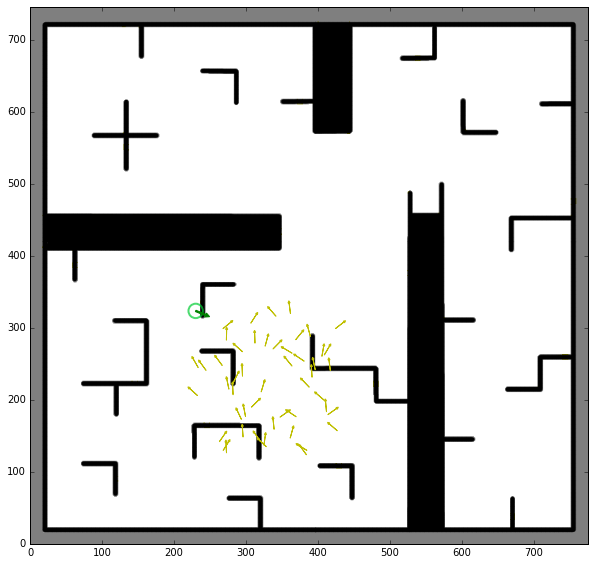

In [44]:

ax= inspercles.nb_draw_map(color_image, pose=pose, robot=True)
draw_particles(particles,ax)

In [45]:
#5

def deslocamento(x,y,theta, std_x=5,std_y=5,std_theta=math.pi/30):
    delta_x = np.random.normal(-std_x,std_x)
    delta_y = np.random.normal(-std_y,std_y)
    delta_theta = np.random.normal(-std_theta,std_theta)
    
    x = x + delta_x
    y = y + delta_y
    theta =  theta + delta_theta
    return (x, y, theta)

def cria_descolamento(particulas):
    particles = []
    for i in particulas:
        i[0], i[1], i[2] = deslocamento(i[0],i[1],i[2])
        particles.append(i)
        
    return particles

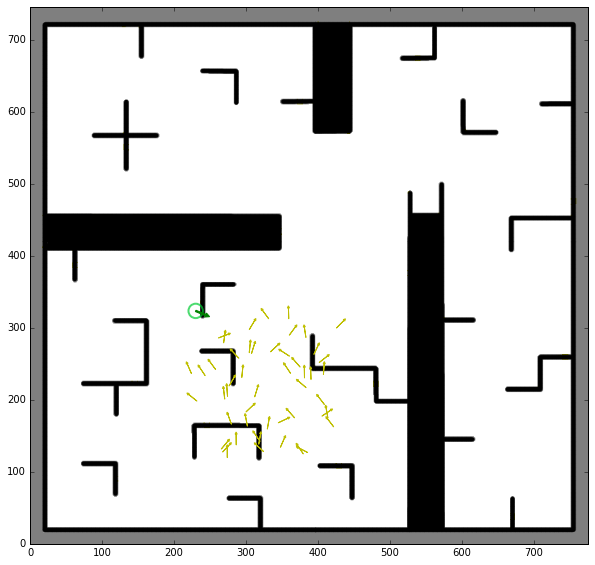

In [46]:
particles = cria_descolamento(particles)
ax= inspercles.nb_draw_map(color_image, pose=pose, robot=True)
draw_particles(particles,ax)


In [47]:
def pdh(angles,zj,_zj,sig):
    count = 1
    for i in range(0,len(angles)):   
        count *= math.e**((-(zj[angles[i]]-_zj[angles[i]]))/(2*sig**2))
    return count       

In [48]:
leituras_reais, lidar_map = inspercles.nb_simulate_lidar(pose, angles, np_image)
prob_before = []
prob_after = []
for i in particles: 
    leitura_part, lidar_part_map = inspercles.nb_simulate_lidar(i, angles, np_image)
    prob_before.append(pdh(angles, leituras_reais,leitura_part, 5)) # sigma = 5
total = sum(prob_before)
for i in range(0,len(prob_before)):
    prob_after.append(prob_before[i]/total)

In [49]:
prob_after

[4.043643176635028e-09,
 4.548013455694137e-12,
 1.763548032513737e-16,
 2.8893891979825967e-08,
 0.26544965796958553,
 0.0004744121887000464,
 0.035622475216269364,
 7.136890808591843e-05,
 6.415319470728614e-14,
 0.02502880036568681,
 6.939700030914739e-09,
 6.981338298329664e-12,
 9.870571929544382e-09,
 2.8379744997086045e-10,
 1.6934626034718067e-11,
 8.327287740965689e-05,
 0.010034056238598226,
 4.469329520464021e-12,
 0.00023521060045448758,
 5.893397099705247e-09,
 1.3394712197406847e-09,
 0.0014168826221733937,
 7.042559984019542e-13,
 7.778891695321608e-12,
 1.447220054852393e-07,
 5.1425641547126656e-11,
 2.4573883069896895e-11,
 7.030936021993264e-12,
 3.618739745918195e-06,
 0.0006914553486480796,
 8.975036411374924e-06,
 0.39920403061857895,
 0.25532910516972457,
 1.149072897597064e-09,
 0.00039921973714113744,
 3.531608479274849e-05,
 4.3573694683327916e-09,
 1.7851672382956699e-09,
 4.6670529852330745e-07,
 2.8192034108244086e-10,
 1.2422190278135635e-12,
 1.1254320281

In [50]:
particulas_reamostragem = Particle.draw_random_sample(particles,prob_after,len(particles))

In [51]:
particulas_reamostragem_comdesvio = []
for i in particulas_reamostragem:
    delta_x = np.random.normal(-2,2)
    delta_y = np.random.normal(-2,2)
    delta_theta = np.random.normal(-2,2)
    x_desv = i[0] + delta_x
    y_desv = i[1] + delta_y
    delta_theta = i[2] + delta_theta
    particulas_reamostragem_comdesvio.append([x_desv,y_desv,delta_theta])
   

## Mapa com posição inicial

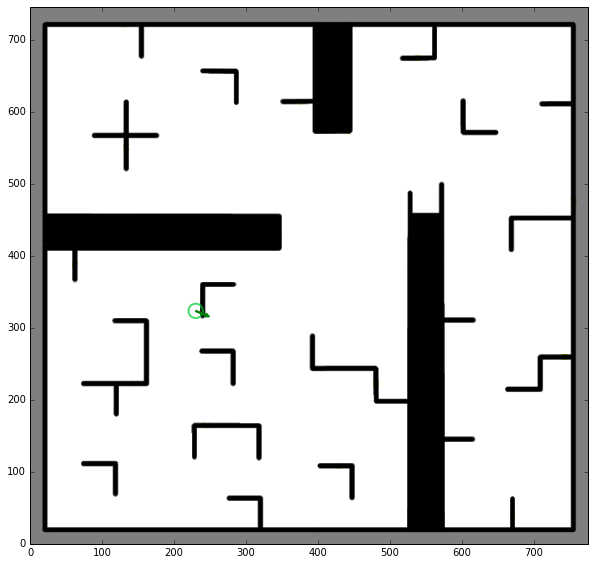

In [52]:
inspercles.nb_draw_map(color_image, pose=pose, robot=True)

A função *nb_initialize_particle_cloud()* pertence ao módulo <code>inspercles</code> e já faz uma primeira aleatorização das partículas

In [53]:
# Inicializa as particulas
particulas = inspercles.nb_initialize_particle_cloud()

In [54]:
angles

array([ 0.        ,  0.8975979 ,  1.7951958 ,  2.6927937 ,  3.5903916 ,
        4.48798951,  5.38558741,  6.28318531])

# Simulação da imagem do laser

Para simular a leitura **real** do robo, use *nb_simulate_lidar* passando a posição real do robô, os ângulos do sensor e a np_image com o mapa

In [55]:
leituras, lidar_map = inspercles.nb_simulate_lidar(pose, angles, np_image)


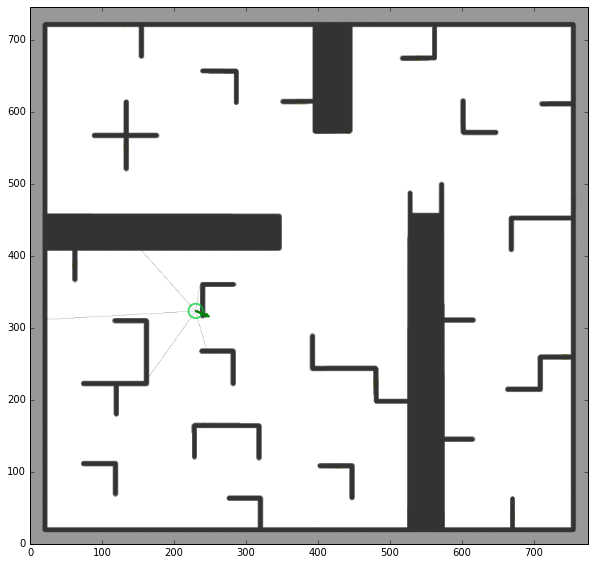

In [56]:
ax = inspercles.nb_draw_map(lidar_map, robot=True, pose=pose)
ax.imshow(color_image, alpha=0.8)
#nb_draw_map(occupancy_image)

As leituras serao retornadas pela simulacao do lidar. Sao armazenadas na forma de um dicionario com angulo: valor da leitura

In [57]:
# As predicoes teoricas das leituras
leituras

{0.0: 90.06664199358161,
 0.89759790102565518: 96.03348780825544,
 1.7951958020513104: 132.5772539964889,
 2.6927937030769655: 195.72237051233066,
 3.5903916041026207: 81.95336374470835,
 4.4879895051282759: 91.48596550435609,
 5.3855874061539311: 66.58439725854318,
 6.2831853071795862: 90.06664199358161}

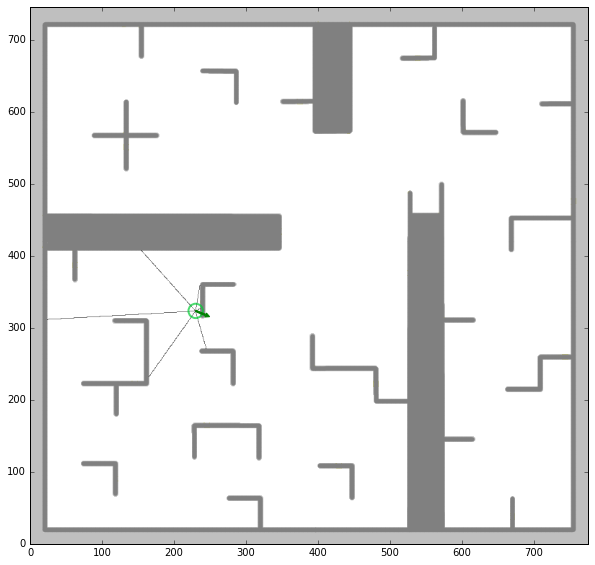

In [58]:
ax = inspercles.nb_draw_map(lidar_map, pose=pose, robot=True)
#ax.imshow(occupancy_image, alpha=0.2)
ax.imshow(pil_image, alpha=0.5)

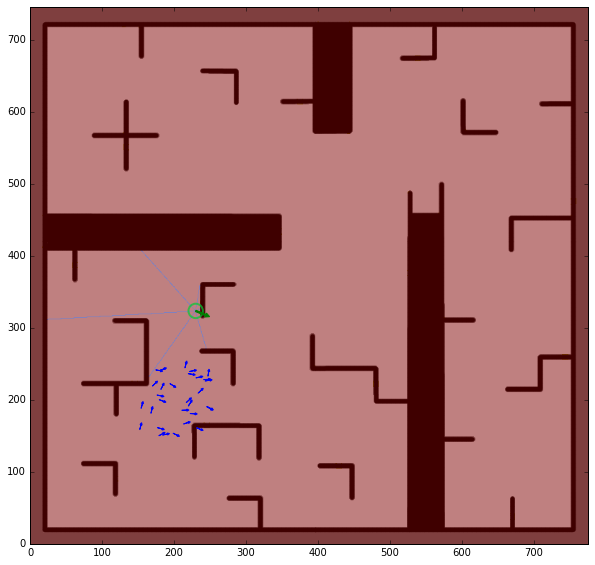

In [59]:
ax = inspercles.nb_draw_map(pil_image, pose=pose, robot=True, particles=particulas)
#ax.imshow(occupancy_image, alpha=0.2)
ax.imshow(lidar_map, alpha=0.5)

## Gerando uma animação

In [60]:
# Coloque nesta lista os deslocamentos do robo

movimentos = [[-10, -10, 0], [-10, 10, 0], [-10,0,0], [-10, 0, 0],
              [0,0,math.pi/12.0], [0, 0, math.pi/12.0], [0, 0, math.pi/12],[0,0,-math.pi/4],
              [-5, 0, 0],[-5,0,0], [-5,0,0], [-10,0,0],[-10,0,0], [-10,0,0],[-10,0,0],[-10,0,0],[-15,0,0],
              [0,0,-math.pi/4],[0, 10, 0], [0,10,0], [0, 10, 0], [0,10,0], [0,0,math.pi/8], [0,10,0], [0,10,0], 
              [0,10,0], [0,10,0], [0,10,0],[0,10,0],
              [0,0,-math.radians(90)],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0]
              
              ]


In [61]:
plt.ioff() # Desliga o modo interativo, para nao aparecerem muitas imagens no meio

frames = 1

for delta in movimentos:
    for i in range(len(pose)):
        pose[i]+=delta[i]
            
        # Simula a leitura do lidar
    leituras, lidar_map = inspercles.nb_simulate_lidar(pose, angles, np_image)

    # Desenha as particulas
    ax = inspercles.nb_draw_map(color_image, pose=pose, robot=True, particles=particulas)
    #ax.imshow(occupancy_image, alph.2)
    # Desenha o mapa do lidar
    ax.imshow(lidar_map, alpha=0.5)
    
    plt.savefig("anim%04d.png"%frames, bounds="tight")
    
    frames+=1
    plt.close('all')


plt.ion()



Para gerar os gifs é preciso ter o pacote *imagemagick*

O imagemagick pode ser obtido com o seguinte comando:
    sudo apt-get install imagemagick 
    
Agora vamos invocar na linha de comando o seguinte comando:
    convert -delay 10 -loop 1 anim*png animated.gif
    
Este comando criou um arquivo chamado *animated.fig*, que leremos abaixo:
    

In [62]:
!convert -delay 10 -loop 1 anim*png animated.gif

Infelizmente o IPython Notebook 2 nao parece exibir animacoes em Gif por default, mas voce pode abrir o arquivo no diretorio de trabalho e devera'  ve-lo.

<img src="animated.gif">

![](anim.gif)